# EDA & Logistic fit of Moody's Industrial Manual Bankruptcy Data

Just a short jaunt through some data sourced from Johnson and Wichern. The end model fit at the end of this notebook isn't great -- poor parameter estimates, residual analysis, and multiple influential points -- but it's prediction of bankruptcies (without using a train/test split) aren't terrible. This underscores the fact that even poor models can be useful. But one would be wise to avoid inferring anything about what is driving the prediction from such a model. Research, experience, and a bit of intuition would be the best guides in that situation. 

In [109]:
# Influence Function
influence = function(fit){
##=================================================================
# This functions takes a fitted model and calculates influence    
# statistics. Implicitly assumes logistic regression.   
##===========================================================

    Hii = hatvalues(fit)
    rp = residuals(fit, type='pearson')
    rsp = rp/(1-Hii)**0.5
    dev = residuals(fit, type='deviance')

    # Calculate statistics.
    deltaChi = rsp**2
    deltaDev = Hii*deltaChi + dev**2
    D = cooks.distance(fit)

    #Draw plots
    par(mfrow=c(1,3))
    options(repr.plot.width=7, repr.plot.height=7)
    plot( deltaChi,
         cex.main = 0.9,
         cex.lab=0.9,
         xlab = "",
         ylab = "Delta Chi",
         main = "Delta Chi vs. Obs", col = "red",type = 'l') 

    plot(deltaDev,
         cex.main = 0.9,
         cex.lab=0.9,
         xlab = "",
         ylab = "Delta Dev",
         main = "Delta Deviance vs. Obs", col="red",type = 'l')

    plot(D,
         cex.main = 0.9,
         cex.lab=0.9,
         xlab = "",
         ylab = "Cook's D",
         main = "Cook's D vs. Obs", col="red", type = 'l')

}

# Residual analysis for logistic reg
residual_plot = function(fit){
##=====================================================================
# Takes logistic fit, plots residuals with lowess smooth.
##=====================================================================
    
    # Lowess smooth should be approximately horizontal through 0.
    resi = residuals(fit, type='deviance')
    plot(fit$fitted.values, resi,
         cex.main = .9, 
         cex.lab = .9,
         col = 'red',  
         main = "Deviance Residuals vs. pi hat",
         xlab = 'pi hat',
         ylab = "Deviance Residuals")
    lines(lowess(resi,fit$fitted.values), col = 'blue')
    legend (0.7, 2.5 , legend=c("Scatter", "Lowess"),
           col=c("red", "blue"), lty=1, box.lty=0, pt.cex = 1, cex = 0.5, y.intersp = 3) 
}

Warning message:
"package 'plot3D' was built under R version 3.6.3"Warning message:
"package 'caret' was built under R version 3.6.2"Loading required package: lattice
Warning message:
"package 'lattice' was built under R version 3.6.2"Loading required package: ggplot2
Warning message:
"package 'ggplot2' was built under R version 3.6.2"

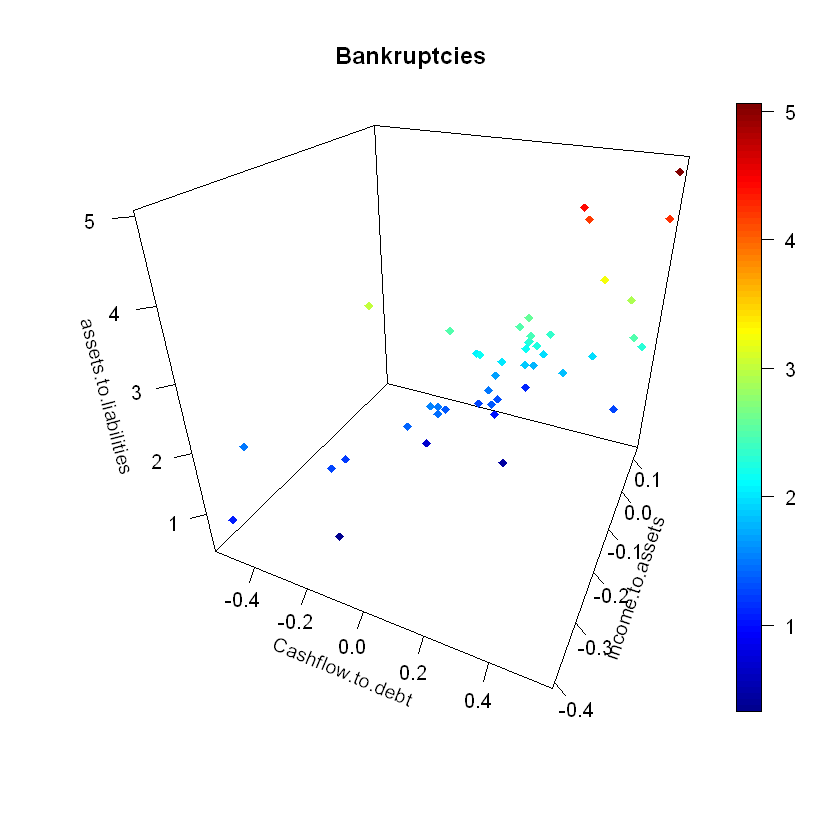

In [1]:
library(plot3D)
library(caret)
#install.packages("plot3D")

#Load data from file.
# Source: 1968-72 Moody's Industrial Manual, as cited in Johnson and Wichern
data=read.table("T11-4.dat",header=FALSE)

#Apply labels to columns
colnames(data) = c('cashflow.debt.ratio',
                   'net.income.to.assets',
                   'assets.to.liabilities',
                   'assets.to.sales',
                   'Non.bankrupt')
x1=data[,1]
x2=data[,2]
x3=data[,3]

# Plot first three variables in space.
scatter3D(x1,x2,x3, 
          phi = 30, 
          theta=25,
          ticktype="detailed", 
          xlab = 'Cashflow.to.debt',
          ylab = 'income.to.assets',
          zlab = 'assets.to.liabilities',
          pch = 18,
          main="Bankruptcies")

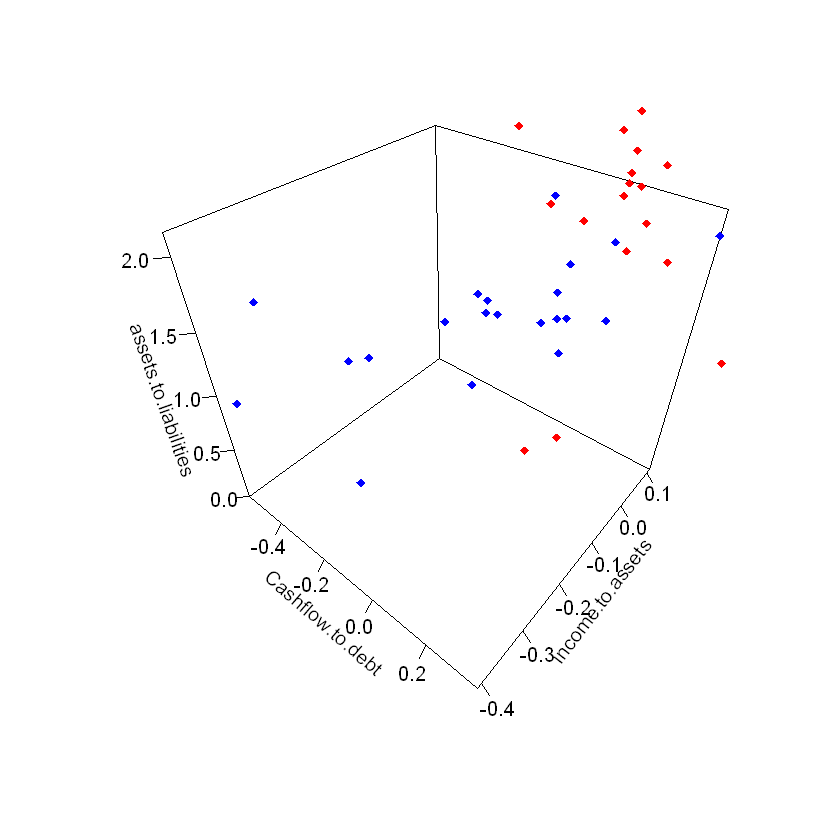

In [2]:
# Create dummy vars to plot observations by group.

# Non-bankrupt
dummy1 = data[,5]
x11 = x1*dummy1
x21 = x2*dummy1
x31 = x3*dummy1

# Bankrupt
dummy2 = (data[,5]-1)*(-1) 
x12 = x1*dummy2
x22 = x2*dummy2
x32 = x3*dummy2

# Plot non-bankrupt
scatter3D(x12,x22,x32,
          col='blue', 
          colvar=NULL,
          ticktype='detailed',
          xlab = 'Cashflow.to.debt',
          ylab = 'income.to.assets',
          zlab = 'assets.to.liabilities',
          pch = 18)

# Add bankrupt points
scatter3D(x11,x21,x31,
          add=TRUE, 
          col='red', 
          colvar=NULL,
          pch=18)

 Bankrupt firms appear to be clustered together. A rough discriminant function appears to be the plane that passes
 thru x_3 = 2 that is parallel to the $x_1$-$x_2$ plane. Observations with $x_{32}$ > 2 are more likely to be non-bankrupt, 
 while those with $x_3$ < 2 tend to be bankrupt. There are exceptions to this rule, though. There are five observations
 with $x_3$ < 2 that are non-bankrupt:

| $x_1$   | $x_2$    | $x_3$  | $x_4$  |
|-------|--------|------|------|
| 0.17  | 0.07   | 1.80 | 0.52 |
| 0.14  | -0.03  | 0.46 | 0.26 |
| 0.29  | 0.06   | 1.84 | 0.38 |
| 0.48  | 0.09   | 1.24 | 0.18 |
| 0.20  | 0.08   | 1.99 | 0.30 |

 These observations could potentially have an effect on a classification rule involving the mean 
 value of the $x_{3}$ variable.

# Assess distribution of the variables

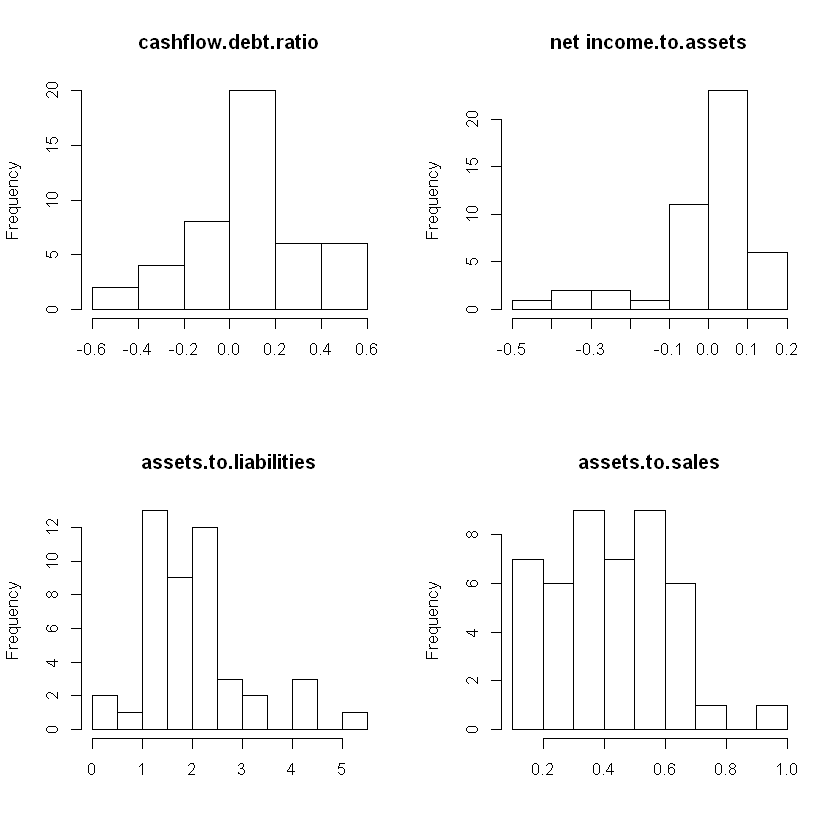

In [3]:
# Plot histograms of the individual variables
par(mfrow=c(2,2))
hist(data[,1], main='cashflow.debt.ratio', xlab=NULL)
hist(data[,2], main='net income.to.assets', xlab=NULL)
hist(data[,3], main='assets.to.liabilities', xlab=NULL)
hist(data[,4], main='assets.to.sales', xlab=NULL)

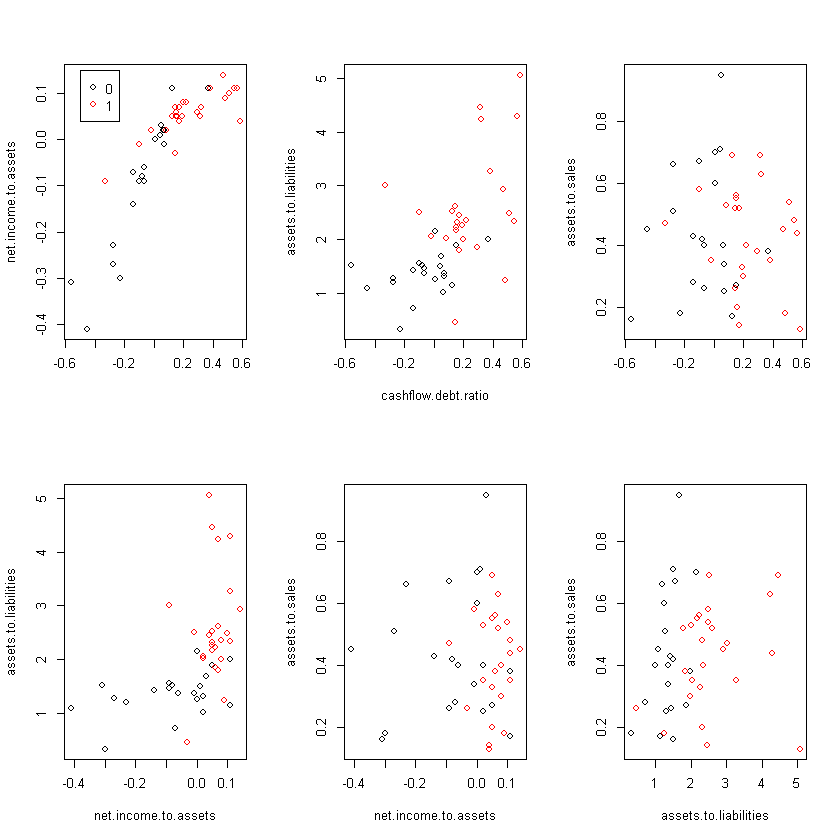

In [38]:
par(mfrow=c(2,3))
plot(data$cashflow.debt.ratio, data$net.income.to.assets,
     xlab = "",
     ylab = 'net.income.to.assets',
     col=factor(data$Non.bankrupt))
legend(-.5,.15,unique(data$Non.bankrupt),col=1:length(data$Non.bankrupt),pch=1)
plot(data$cashflow.debt.ratio, data$assets.to.liabilities,
     xlab = 'cashflow.debt.ratio',
     ylab = 'assets.to.liabilities',
     col=factor(data$Non.bankrupt))
plot(data$cashflow.debt.ratio, data$assets.to.sales,
     xlab = "",
     ylab = 'assets.to.sales',
     col=factor(data$Non.bankrupt))
plot(data$net.income.to.assets, data$assets.to.liabilities,
     xlab = 'net.income.to.assets', 
     ylab = 'assets.to.liabilities',
     col=factor(data$Non.bankrupt))
plot(data$net.income.to.assets, data$assets.to.sales,
     xlab = 'net.income.to.assets', 
     ylab = 'assets.to.sales',
     col=factor(data$Non.bankrupt))
plot(data$assets.to.liabilities, data$assets.to.sales,
     xlab = 'assets.to.liabilities', 
     ylab = 'assets.to.sales',
     col=factor(data$Non.bankrupt))


# Fit logistic model

In [100]:
fit = glm(Non.bankrupt~cashflow.debt.ratio+net.income.to.assets+assets.to.liabilities+assets.to.sales, 
          data = data, 
          family = binomial(link=logit))
summary(fit)


Call:
glm(formula = Non.bankrupt ~ cashflow.debt.ratio + net.income.to.assets + 
    assets.to.liabilities + assets.to.sales, family = binomial(link = logit), 
    data = data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.30416  -0.44545   0.00725   0.49102   2.62396  

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)   
(Intercept)             -5.320      2.366  -2.248  0.02459 * 
cashflow.debt.ratio      7.138      6.002   1.189  0.23433   
net.income.to.assets    -3.703     13.670  -0.271  0.78647   
assets.to.liabilities    3.415      1.204   2.837  0.00455 **
assets.to.sales         -2.968      3.065  -0.968  0.33286   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 63.421  on 45  degrees of freedom
Residual deviance: 27.443  on 41  degrees of freedom
AIC: 37.443

Number of Fisher Scoring iterations: 7


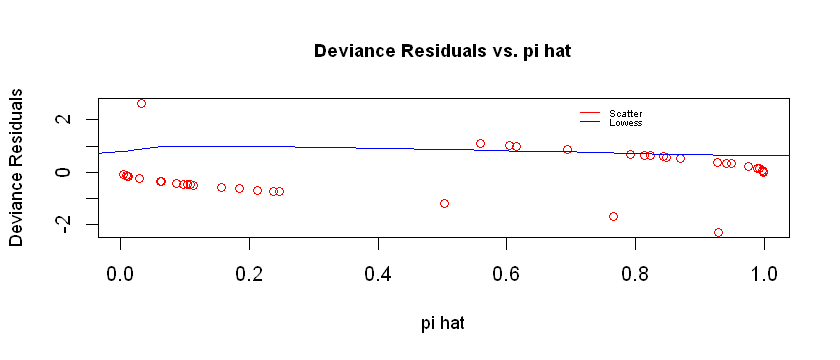

In [101]:
# Note: This is clearly a poor fit. Blue lowess smooth should be centered at 0.
residual_plot(fit)

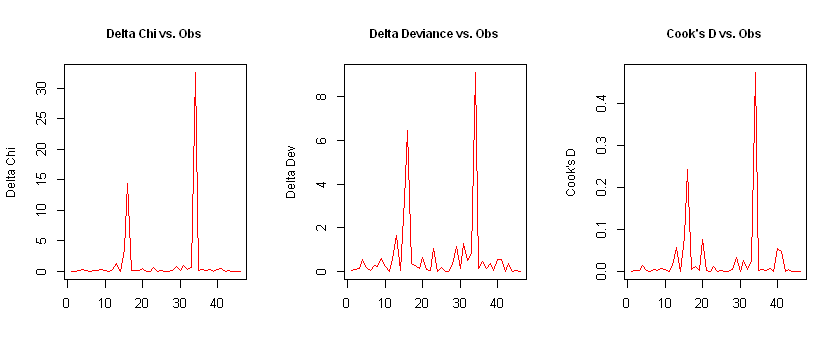

In [102]:
# *At least* two highly influential observations. 
influence(fit)

In [104]:
# Model predictions fairly good on the whole dataset considering the poor fit.
# Train/test split would likely shed more light on how well the model fairs in general.
cm = confusionMatrix(factor(as.integer(fit$fitted.values - .5 >= 0)),
                     factor(data$Non.bankrupt),
                     positive='1')
cm

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 18  1
         1  3 24
                                          
               Accuracy : 0.913           
                 95% CI : (0.7921, 0.9758)
    No Information Rate : 0.5435          
    P-Value [Acc > NIR] : 5.991e-08       
                                          
                  Kappa : 0.8234          
                                          
 Mcnemar's Test P-Value : 0.6171          
                                          
            Sensitivity : 0.9600          
            Specificity : 0.8571          
         Pos Pred Value : 0.8889          
         Neg Pred Value : 0.9474          
             Prevalence : 0.5435          
         Detection Rate : 0.5217          
   Detection Prevalence : 0.5870          
      Balanced Accuracy : 0.9086          
                                          
       'Positive' Class : 1               
                                    